In [1]:
#### Import Dataset from DropBox
! wget -q "https://www.dropbox.com/s/mykvyi2rm8j267v/IMDB%20Dataset.csv?dl=0" -O "IMDB_dataset.csv"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchtext.legacy import data
from collections import defaultdict

In [3]:
#### CONFIGURATION FOR PLOTS
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [4]:
import nltk
from string import punctuation
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
import time
import spacy
NLP = spacy.load('en')
import re
import torch
from torch import nn, optim
import torch.nn.functional as F
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [111]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

LOAD DATA

In [7]:
IMDB_data = pd.read_csv("IMDB_dataset.csv")

In [8]:
len(IMDB_data)

50000

In [70]:
IMDB_data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. the filming tec...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,petter mattei's love in the time of money is a...,1


# **DATA PREPROCESSING**

In [10]:
###Checking if there are any null points or empty points // missing data
IMDB_data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [11]:
def replace(x):
  """
    This function is a lambda for each sentiment column: Replaces 'pos'-> 1 and 'neg'-> 0
  """
  if x == 'positive':
    return 1
  elif x == 'negative':
    return 0

In [12]:
IMDB_data['sentiment']  = IMDB_data['sentiment'].apply(lambda x: replace(x)) ## replaces 'positive' -> 1 and 'negative' -> 0

In [13]:
def remove_punc_word(word):
    punc = '''()-[]{};:'"\,<>.£+/@#$%^&*_”+–~’’=“–।”–’’||'''
    for ele in word:  
      if ele in punc:  
        word = word.replace(ele, "") 
    return word

In [73]:
class Preprocessing:
    """
    This is the parent ProeProcessing Class, that removes punctuation, removes html tags, URLs and does PreProcessing

    """

    def __init__(self, pre = True ):
        self.flag = pre

    def run(self, raw_str):

        preprocessed_str = ((self.remove_punctuation((self.remove_URL(self.remove_htmltags(self.remove_users(raw_str)))))).lower())
        return preprocessed_str

    def only_nonascii(self, input_str):
        """Substitutes ASCII characters with empty string"""
        _ascii_letters = re.compile(r'[a-zA-Z0-9/.:-]', flags=re.UNICODE)
        return _ascii_letters.sub("", input_str)

    def remove_URL(self, input_str):
        """Remove URLs from an input string"""
        return re.sub(r"http\S+", "", input_str)
        
    def remove_users(self, input_str):
        """Removes strings @userhandle to clean twitter data"""
        raw_str = re.sub(r"@\w+", '', input_str).strip() # .lstrip('RT').lstrip('QT')
        final_str = re.sub('RT|QT' , '', str(raw_str))
        return final_str

    def remove_htmltags(self, input_str):
        """Removes html tags of the form <any character(s)> from an input string"""
        return re.sub(r"<.*?>", "", input_str)

    def remove_non_ascii(self, input_str):
        """Remove non-ASCII characters from an input string"""
        tokenized_words = word_tokenize(input_str)
        tokens = []
        for token in tokenized_words:
            cleaned_token = unicodedata.normalize('NFKD', token).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            tokens.append(cleaned_token)
        return ' '.join(tokens)
    
    def remove_punctuation(self, sample_str):
        """Remove punctuation from a input string"""
        comment = sample_str
        comment = re.sub(
        r"[\*\"“”\|\~\n\\\@\{\}\%\_\#\^\&\$\£\+\<\>\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", 
        str(comment))
        comment = re.sub(r"[ ]+", " ", comment)
        comment = re.sub(r"\!+", "!", comment)
        comment = re.sub(r"\,+", ",", comment)
        comment = re.sub(r"\?+", "?", comment)
        return comment


    def replace_nan(self, input_str):
        """Replacing nan strings with empty strings - required for textrank"""        
        input_str = re.sub('nan' , '' , str(input_str))
        return input_str
    


In [15]:
preprocessor = Preprocessing(True)
IMDB_data['review'] = IMDB_data['review'].apply(lambda x: preprocessor.run(x)) ## The DataFrame has PreProcessed text

In [74]:
IMDB_data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. the filming tec...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,petter mattei's love in the time of money is a...,1


# **ANALYSING SENTIMENT**

NEGATIVE REVIEW

In [116]:
print(f"Sentiment  = {IMDB_data.at[3, 'sentiment']}")

Sentiment  = 0


In [117]:
(IMDB_data.at[3, 'review'])

"basically there's a family where a little boy jake thinks there's a zombie in his closet his parents are fighting all the time.this movie is slower than a soap opera... and suddenly, jake decides to become rambo and kill the zombie.ok, first of all when you're going to make a film you must decide if its a thriller or a drama as a drama the movie is watchable. parents are divorcing arguing like in real life. and then we have jake with his closet which totally ruins all the film i expected to see a boogeyman similar movie, and instead i watched a drama with some meaningless thriller spots.3 out of 10 just for the well playing parents descent dialogs. as for the shots with jake just ignore them."

POSITIVE REVIEW

In [118]:
print(f"Sentiment  = {IMDB_data.at[1, 'sentiment']}")

Sentiment  = 1


In [119]:
(IMDB_data.at[1, 'review'])

"a wonderful little production. the filming technique is very unassuming very old time bbc fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. a masterful production about one of the great master's of comedy and his life. the realism really comes home with the little things the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. it plays on our knowledge and our senses, particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwell's murals decorating every surface are terribly well done."

In [ ]:
### INFERENCE : on analysing the data is labelled fine and the sentiments of the sentence is given by the label

# **VISUALIZATION**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


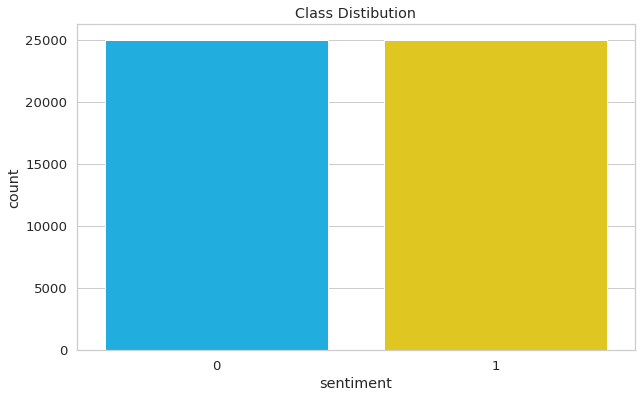

In [ ]:
####### PLOT 1
plt.figure(figsize = (10, 6))
plt.title("Class Distibution")
sns.countplot(IMDB_data['sentiment'])

In [ ]:
###Inference: We can see that it is a perfectly balanced distribution with equal representation from each class

ANALYSIS OF REVIEW LENGTH

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


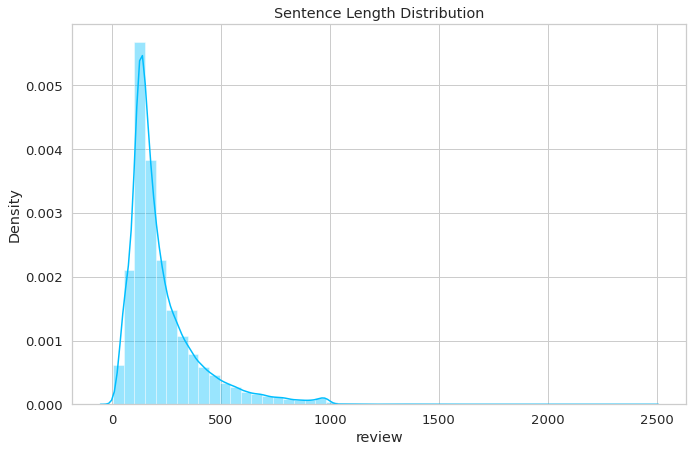

In [ ]:
###### PLOT 2
plt.figure(figsize = (11, 7))
plt.title("Sentence Length Distribution")
sns.distplot((IMDB_data['review'].apply(lambda x: len(x.split(' ')))))

In [ ]:
### INFERENCE 
## The sentence length distribution mostly looks like a distorted Gaussian Distribution
## The mean of the Distribution of sentence length is around 250 words
### Hence we take a maximum lenght of sentences as 300 words
### MAX LENGTH = 300

In [ ]:
### PLOT 3 , anlaysing most occuring bigrams in text
STOPWORDS = list((stopwords.words('english')))

def generate_ngrams(text, n_gram = 2):
  token_list = [token for token in text.split(' ') if token != '' if token not in STOPWORDS]
  ngrams = zip(*[ token_list[i:] for i in range(n_gram)]  )
  return [' '.join(ngram) for ngram in ngrams]

ngram_dict = defaultdict(int)
for row in IMDB_data['review']:
  for pair in generate_ngrams(row):
    ngram_dict[pair] += 1

df_ngram = pd.DataFrame(sorted(ngram_dict.items(), key=lambda x: x[1])[::-1])

Text(0.5, 0, 'Frequency')

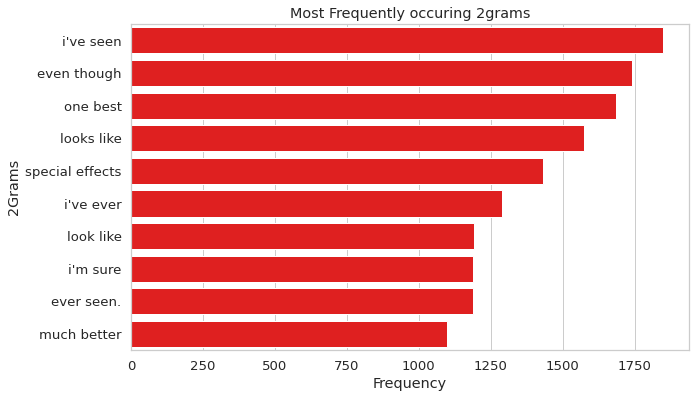

In [ ]:
plt.figure(figsize= (10, 6))
plt.title("Most Frequently occuring 2grams")
sns.barplot(y=df_ngram[0].values[:10], x=df_ngram[1].values[:10], color='red')
plt.ylabel("2Grams")
plt.xlabel("Frequency")

TRAIN TEST SPLIT

In [16]:
# split the data into train and test set
train, test  =    train_test_split(IMDB_data, test_size=0.2, random_state=42, shuffle=True)
##### 40000 samples for train and 10000 samples for test

In [18]:
train.to_csv('train.csv')
test.to_csv('test.csv')

TOKENIZATION

In [19]:
def tokenizer(comment):
    """ 
    This performs the tokenization of text using Spacy
    """
    return [x.text for x in NLP.tokenizer(comment) if x.text != " "]

PADDING AND VOCAB

In [20]:
#### Note based on the plot, we can conclude that we can fix a MaxLength = 300, which is nominal
MAX_LENGTH = 300
TEXT = data.Field(sequential=True, fix_length = MAX_LENGTH, tokenize=tokenizer, lower=True)
LABEL = data.Field(sequential=False, use_vocab=False)

In [21]:
fields = {'review': ('t', TEXT), 'sentiment': ('l', LABEL)}

In [22]:
train_data, test_data = data.TabularDataset.splits(
                                        path = '',
                                        train = 'train.csv',
                                        test = 'test.csv',
                                        format = 'csv',
                                        fields = fields
                                        
)

In [23]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 40000
Number of testing examples: 10000


BUILD VOCAB WITH GLOVE EMBEDDINGS

In [24]:
print(vars(train_data.examples[11])) ###Example train_data

{'t': ['this', 'movie', 'was', 'so', 'bad', 'and', 'so', 'cheap', 'and', 'so', 'corny', ',', 'i', 'found', 'this', 'movie', 'to', 'be', 'one', 'of', 'the', 'most', 'boring', 'slow', 'paced', 'early', '80', "'s", 'movies', 'that', 'i', 'have', 'ever', 'seen', '.', 'i', 'like', 'most', '80', "'s", 'cheap', 'horror', 'movies', 'but', 'i', 'would', 'never', 'rent', 'this', 'one', 'again', '.', 'it', 'just', 'did', 'not', 'make', 'any', 'sense', '.', 'a', 'family', 'that', 'lives', 'in', 'the', 'woods', 'invites', 'their', 'son', ',', 'his', 'wife', 'and', 'their', 'daughter', 'to', 'spend', 'time', 'with', 'them', 'for', 'the', 'holidays', 'and', 'during', 'the', 'movie', 'for', 'some', 'reason', 'the', 'mother', 'and', 'daughter', 'in', 'law', 'do', 'not', 'get', 'along', 'well', '.', 'we', 'never', 'figure', 'out', 'why', 'until', 'almost', 'till', 'the', 'end', 'of', 'the', 'movie', 'but', 'until', 'then', ',', 'all', 'we', 'see', 'is', 'the', 'fact', 'that', 'the', 'mother', 'has', 'so

In [25]:
#### We build the vocabulary of Fields based on text
MAX_VOCAB_SIZE = 50000


TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                          
 99%|█████████▉| 397183/400000 [00:14<00:00, 29014.15it/s]

In [ ]:
print(LABEL.vocab.freqs.most_common(20))

[('0', 20039), ('1', 19961)]


In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 50002
Unique tokens in LABEL vocabulary: 3


BATCHING AND LOADING

In [75]:
BATCH_SIZE = 50 ### Given in question

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = False, # lambda x: len(x.text),
    device = device)

MODEL DESIGNING

In [110]:
class LSTMModel(nn.Module):
  """
  This is the Model Class that is used for training the classifier
  """
  def __init__(self,   num_directions,  batch_size, output_dimension, hidden_dimension , 
               vocab_size,embedding_dimension, num_layers, dropout, pad_idx):
    """
    Inititalises the layers and variables
    """
    self.vocab_size = vocab_size
    self.num_layers = num_layers
    self.hidden_dimension = hidden_dimension
    self.output_dimension = output_dimension
    self.batch_size = 50
    self.num_directions = num_directions

    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dimension, padding_idx = pad_idx)
    self.LSTM = nn.LSTM(embedding_dimension, hidden_dimension, num_layers ,  bidirectional = True)
    self.linear = nn.Linear(hidden_dimension*2, output_dimension)

  def forward(self, x): ##batch_szie * seq_len

    """
    returns outputs after one forward pass

    """
    x = self.embedding(x) ##batch_size*seq_Len*hidden_dimension

    h_0 = torch.zeros(self.num_layers*self.num_directions, self.batch_size, self.hidden_dimension, requires_grad= True ).to(device)
    c_0 = torch.zeros(self.num_layers*self.num_directions, self.batch_size, self.hidden_dimension, requires_grad= True ).to(device)

    _, (h_n, c_n) = self.LSTM(x,   (h_0, c_0))

    x = self.linear( torch.cat(  (h_n[-1,:, :], h_n[-2, :, :] ), dim = 1  ) )###h_n = (num_layers*num_directions*batch*hidden_size)

    return x



In [77]:
#### Following is the model specification ###
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 3
BIDIRECTIONAL = True
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
BATCH_SIZE = 50
DROPOUT = 0.3

model = LSTMModel(2, BATCH_SIZE, OUTPUT_DIM, HIDDEN_DIM, INPUT_DIM, EMBEDDING_DIM,
                  N_LAYERS, DROPOUT, PAD_IDX).to(device)

In [ ]:
model

LSTMModel(
  (embedding): Embedding(50002, 100, padding_idx=1)
  (LSTM): LSTM(100, 256, num_layers=3, bidirectional=True)
  (linear): Linear(in_features=512, out_features=1, bias=True)
)

In [78]:
def count_parameters(model):
  
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,887,817 trainable parameters


In [79]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([50002, 100])


In [80]:
model.embedding.weight.data.copy_(pretrained_embeddings) ### Here we initialise the embedding layer with PreTrained Embeddings

tensor([[ 1.9269,  1.4873,  0.9007,  ...,  0.1233,  0.3499,  0.6173],
        [ 0.7262,  0.0912, -0.3891,  ...,  0.0821,  0.4440, -0.7240],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.3304,  0.0942, -0.0592,  ..., -0.4125, -0.9753,  0.1846],
        [-0.0577, -0.2255, -0.4133,  ...,  0.7712,  0.0799,  1.1282],
        [ 0.2163, -0.2596, -0.6434,  ...,  0.2349, -0.2631, -0.3824]],
       device='cuda:0')

In [81]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) ### Padding and Unknown index are given a zero tensor
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.3304,  0.0942, -0.0592,  ..., -0.4125, -0.9753,  0.1846],
        [-0.0577, -0.2255, -0.4133,  ...,  0.7712,  0.0799,  1.1282],
        [ 0.2163, -0.2596, -0.6434,  ...,  0.2349, -0.2631, -0.3824]],
       device='cuda:0')


In [83]:
############## Optimizer and Loss Function #################
EPOCHS = 5
optimizer = optim.AdamW(model.parameters()) 
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [84]:
def accuracy(preds, y):
  """
  This function returns the accuracy given the true predictions and the model predictions
  """
  preds = torch.round(torch.sigmoid(preds))
  correct = (preds == y).float()
  acc = correct.sum()/len(correct)

  return acc

TRAINING

In [85]:
def train_epoch(model, iterator, optimizer, criterion):
  """
  This function trains the model, i.e forwward propopgates and backward 
  propogates for complete train set for one epoch
  """
  epoch_loss = 0
  epoch_acc = 0
  i = 0
  for batch in iterator:

        optimizer.zero_grad()
        
        text = (batch.t).to(device)
        
        predictions = model(text).squeeze(1)
        #predictions = predictions.long()
        target = batch.l.type_as(predictions)
        loss = criterion(predictions, target)
        
        acc = accuracy(predictions.long(),batch.l)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #return predictions.long(), batch.l
  return epoch_loss / len(iterator), epoch_acc / len(iterator)
    

In [42]:
################### This cell repeatedly calls the train_epoch function for N_EPOCHS times
N_EPOCHS = 5

for epoch in range(N_EPOCHS):


    train_loss, train_acc = train_epoch(model, train_iterator, optimizer, criterion)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} ')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    

Epoch: 01 
	Train Loss: 0.540 | Train Acc: 66.75%
Epoch: 02 
	Train Loss: 0.263 | Train Acc: 88.60%
Epoch: 03 
	Train Loss: 0.150 | Train Acc: 94.29%
Epoch: 04 
	Train Loss: 0.079 | Train Acc: 97.47%
Epoch: 05 
	Train Loss: 0.041 | Train Acc: 98.89%


In [108]:
print(f"Train Accuracy: {train_acc}%     Train Loss: {train_loss}")

Train Accuracy: 98.89%     Train Loss: 0.041


In [109]:
def evaluate(model, iterator, criterion):
    """
    This function returns the evaluation result for model.
    If evaluation is to be done on test set, then test_iterator needs to be passed
    """

    epoch_loss = 0
    epoch_acc = 0
    i = 0

    true_labels = []
    predicted_labels = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            
            text = (batch.t).to(device)

            predictions = model(text).squeeze(1)
        
            target = batch.l.type_as(predictions)
            loss = criterion(predictions, target)
            
            acc = accuracy(predictions.long(),batch.l)
            preds = torch.round(torch.sigmoid(predictions))

            predicted_labels.extend(preds.cpu().numpy())
            true_labels.extend(target.cpu().numpy())

            epoch_loss += loss.item()
            
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), true_labels, predicted_labels

In [130]:
test_iterator.sort = False

TEST RESULTS

In [102]:
Test_loss, Test_acc, True_labels, Predicted_labels = evaluate(model, test_iterator, criterion)

In [121]:
print(classification_report(True_labels, Predicted_labels))

              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88      4961
         1.0       0.87      0.90      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [128]:
print(f"Test Accuracy obtained : {Test_acc*100}%")

Test Accuracy obtained : 93.527%


In [ ]:
####IGNORE THIS, THE following cells are used to Plot the model

In [ ]:
!pip install hiddenlayer

In [ ]:
import hiddenlayer as hl

transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.

graph = hl.build_graph(model, yhat, transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('rnn_hiddenlayer', format='png')

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:1936: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")
